In [7]:
] activate ../../

Activating environment at `C:\Users\carsten\Desktop\Oulu2020\Project.toml`


## Problem

Optimize the following function.

In [8]:
function work(mat, s, v, N)
    val = 0.0
    for i in 1:N
        for j in 1:N
            val = mod(v[i],256);
            mat[i,j] = s[i,j]*(sin(val)*sin(val)-cos(val)*cos(val));
        end
    end;
end

work (generic function with 1 method)

In [9]:
using Test
x = rand()
@test 1-2*cos(x)*cos(x) ≈ sin(x)*sin(x)-cos(x)*cos(x)
@test -cos(2*x) ≈ sin(x)*sin(x)-cos(x)*cos(x)

Test Passed

In [10]:
# pulling out + analytical opt
function opt1(mat, s, v, N)
    val = 0.0
    @inbounds for i in 1:N
        val = mod(v[i],256);
        val = -cos(2*val)
        for j in 1:N
            mat[i,j] = s[i,j]*val;
        end
    end;
    mat
end

opt1 (generic function with 1 method)

In [11]:
# pulling out + analytical opt + allocate values
function opt12(mat, s, v, N)
    val = Vector{Float64}(undef, length(v))
    @inbounds for i in eachindex(val)
        val[i] = -cos(2*mod(v[i],256));
    end
    
    @inbounds for i in 1:N
        for j in 1:N
            mat[i,j] = s[i,j]*val[i];
        end
    end;
    mat
end

opt12 (generic function with 1 method)

In [12]:
# reordering loops
function opt2(mat, s, v, N)
    val = 0.0
    @inbounds for j in 1:N
        for i in 1:N
            val = mod(v[i],256);
            val = -cos(2*val)
            mat[i,j] = s[i,j]*val;
        end
    end;
end

opt2 (generic function with 1 method)

In [13]:
# reordering loops + allocate values
function opt22(mat, s, v, N)
    val = Vector{Float64}(undef, length(v))
    @inbounds for i in eachindex(val)
        val[i] = -cos(2*mod(v[i],256));
    end
    
    @inbounds for j in 1:N
        for i in 1:N
            mat[i,j] = s[i,j]*val[i];
        end
    end;
end

opt22 (generic function with 1 method)

More optimizations: blocking, tabling values of `val`...

## Single thread benchmarks

In [14]:
using BenchmarkTools
N = 4000
mat = zeros(N,N)
s = rand(N,N)
v = rand(Int, N);

In [15]:
runtime = @belapsed work($mat, $s, $v, $N);
perf = N*N*1e-6/runtime # MIt/s
println("Performance: $perf MIt/s")

Performance: 18.8213549916939 MIt/s


In [16]:
runtime = @belapsed opt1($mat, $s, $v, $N);
perf = N*N*1e-6/runtime # MIt/s
println("Performance: $perf MIt/s")

Performance: 73.55614989844126 MIt/s


In [17]:
runtime = @belapsed opt12($mat, $s, $v, $N);
perf = N*N*1e-6/runtime # MIt/s
println("Performance: $perf MIt/s")

Performance: 69.98399553502108 MIt/s


In [18]:
runtime = @belapsed opt2($mat, $s, $v, $N);
perf = N*N*1e-6/runtime # MIt/s
println("Performance: $perf MIt/s")

Performance: 54.70927169892555 MIt/s


In [19]:
runtime = @belapsed opt22($mat, $s, $v, $N);
perf = N*N*1e-6/runtime # MIt/s
println("Performance: $perf MIt/s")

Performance: 1037.6404057173986 MIt/s


## Multi-threading

In [20]:
using Hwloc
Hwloc.num_physical_cores()

4

In [21]:
Base.Threads.nthreads()

4

In [22]:
function opt22_threaded(mat, s, v, N)
    val = Vector{Float64}(undef, length(v))
    @inbounds for i in eachindex(val)
        val[i] = -cos(2*mod(v[i],256));
    end
    
    @inbounds Threads.@threads for j in 1:N
        for i in 1:N
            mat[i,j] = s[i,j]*val[i];
        end
    end;
    mat
end

opt22_threaded (generic function with 1 method)

In [23]:
runtime = @belapsed opt22_threaded($mat, $s, $v, $N);
perf = N*N*1e-6/runtime # MIt/s
println("Performance: $perf MIt/s")

Performance: 1070.9433002456476 MIt/s


## Maximal performance?

In [250]:
bs = 29 # [GB/s] max memory bandwidth (estimated from STREAM benchmark, 34 GB/s is the Intel value)
flops = 1
traffic = 24 # [B/iter] in each iteration we have: LOAD s, LOAD + STORE mat, each contributing 8 B
I = flops / traffic
println("Memory bounded performance: ", round(I*bs, digits=2), " GIt/s")

Memory bounded performance: 1.21 GIt/s


#### "Roofline model"

In [243]:
using CpuId
clock = cpu_max_frequency() * 1e-3 # [GHz], turbo clock frequency

fma_per_cycle = 2

flops_per_fma = 4*2 # AVX2, 32 byte registers, 4 mul 4 add

flops_per_cycle = flops_per_fma * fma_per_cycle

ncores = cpucores() # used cores

P_peak = clock * flops_per_cycle * ncores # Gflops/s

249.6

Test realistic peak performance using `peakflops`, which is based on [LinearAlgebra.BLAS.gemm!](https://docs.julialang.org/en/latest/stdlib/LinearAlgebra/#LinearAlgebra.BLAS.gemm!), i.e. `C[i] = α*A[i]*B[i]+βC[i]`.

In [161]:
# using LinearAlgebra
# using Statistics
# BLAS.set_num_threads(4)
# p = [peakflops(Int(i*1e3)) * 1e-9 for i in 1:12]
# mean(p[end-2:end])

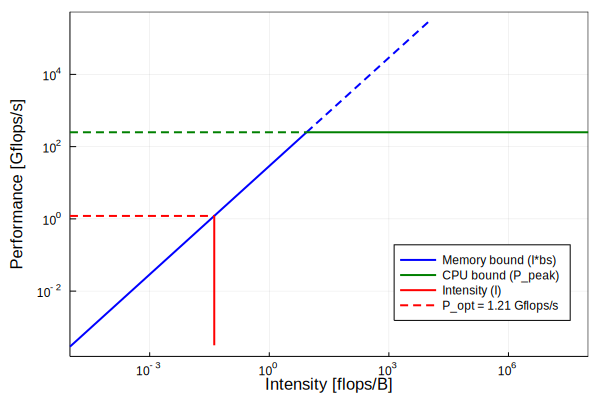

In [252]:
using Plots
# memory bound
plot(x->bs*x, label="Memory bound (I*bs)", frame=:box, color=:blue, xlim=(1e-5,P_peak/bs), lw=2, xscale=:log10, yscale=:log10, legend=:bottomright)
plot!(x->bs*x, label="", frame=:box, color=:blue, xlim=(P_peak/bs,1e4), linestyle=:dash, lw=2)

# cpu bound
plot!([P_peak / bs,1e8],[P_peak, P_peak], label="CPU bound (P_peak)", color=:green, lw=2)
plot!([1e-5,P_peak / bs],[P_peak, P_peak], label="", color=:green, lw=2, ls=:dash)

# intensity (our vecmul!)
plot!([I,I],[10^(-3.5),I*bs], label="Intensity (I)", color=:red, lw=2)
# vline!([I], label="Intensity (I)", color=:red, lw=2)

# max memory bound performance
plot!([1e-5,I],[I*bs,I*bs], label="P_opt = $(round(I*bs, digits=2)) Gflops/s", color=:red, lw=2, ls=:dash)

# ylims!(0,400)
xlims!(1e-5,1e8)
xlabel!("Intensity [flops/B]")
ylabel!("Performance [Gflops/s]")

According to expectation, our kernel computation is clearly memory bound.

In [255]:
# ratio
perf*1e-3/(I*bs)

0.8862979036515706

Our best code above reaches the memory bound estimate to about 89%.